# Set-Up

In [1]:
import jax
import jax.numpy as jnp
import approx_post
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta,0).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = x.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', label=f"Predicted Mean Plus/Minus Predicted Variance", linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze(),0), y=true_theta.squeeze(), label=f"True Relationship", color='g')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Posterior Probability Density")

In [5]:
def plot_logpdf_del_x(ammortised_dist, x=None, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    if x is None:
        theta = jnp.atleast_2d(jnp.linspace(-1, 11, 1000)).reshape(1,-1,1)
    amortised_dist.logpdf_del_x(theta, x)
    
    plt.xlabel("Parameter $\theta$")
    plt.ylabel("Observation $x$")
    plt.zlabel("$\partial_x \, \ln{p(\theta|x)}$")

# Artificial Data Creation

In [6]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta, 0).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [7]:
# Define model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [8]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model_func, true_theta, noise_cov, prngkey)

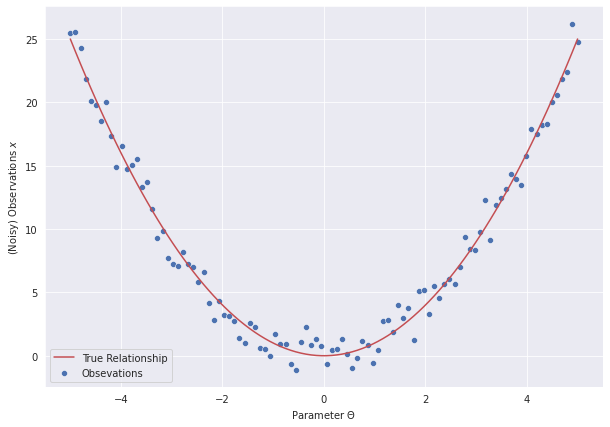

In [9]:
plot_data(data, true_theta, model_func)

# Create Joint Distribution

In [10]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [11]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(ndim)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(data)
amortised_dist = approx_post.distributions.amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=3, width=5,
                                                                   activation='sigmoid', preprocessing=preprocessing)

In [12]:
# # Initialise:
# target = Jaxtainer({'mean': 0, 'log_chol_diag': 0})
# mse = approx_post.losses.MSE(target)
# optimiser = approx_post.optimisers.Adam(lr=5e-3)
# _ = optimiser.fit(amortised_dist, mse, data, prngkey, verbose=True)

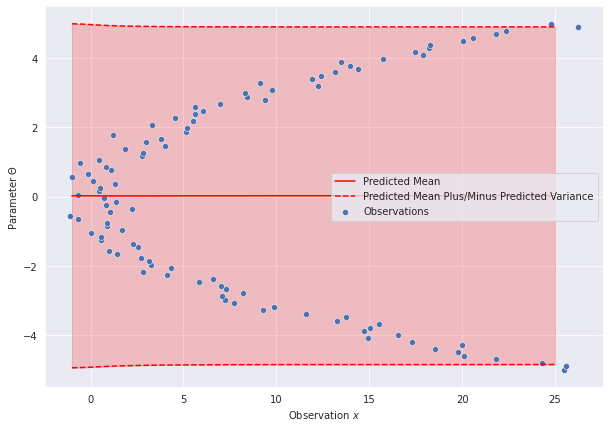

In [13]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [14]:
prngkey = jax.random.PRNGKey(20)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=50)

Loss = 0.002406052080914378, Params = Jaxtainer({'W_0': DeviceArray([[-0.8627346 ,  0.07508685,  2.4704664 ,  1.2239019 ,
               0.5110818 ]], dtype=float32), 'b_0': DeviceArray([-0.09893931, -0.09688733,  0.09351486, -0.08999223,
              0.09868537], dtype=float32), 'W_1': DeviceArray([[ 0.03282148, -0.5588654 , -0.4766611 , -0.31102186,
               0.3372758 ],
             [-0.30640748,  1.0766382 , -1.160264  ,  0.40222907,
               0.18930873],
             [-0.56945527,  0.9202225 ,  0.01873052,  0.2779283 ,
              -0.2336644 ],
             [-0.32167456,  1.1706487 ,  0.6711712 , -0.52894783,
              -0.6483853 ],
             [-1.3489797 ,  0.88667023,  0.9156821 ,  0.4710688 ,
               1.2492231 ]], dtype=float32), 'b_1': DeviceArray([-0.09686159, -0.09550844, -0.09855374, -0.0997496 ,
              0.09908474], dtype=float32), 'W_2': DeviceArray([[ 0.39445043,  0.13505808,  0.9509377 , -0.6660927 ,
              -0.7158334 ],
        

Loss = 0.002381215337663889, Params = Jaxtainer({'W_0': DeviceArray([[-1.1922593 ,  0.10873433,  2.7774622 ,  1.4319712 ,
               0.35359424]], dtype=float32), 'b_0': DeviceArray([-0.41745704, -0.42227066,  0.3888973 , -0.00506707,
             -0.06678174], dtype=float32), 'W_1': DeviceArray([[ 0.4132259 , -0.91951275, -0.10716139,  0.06707866,
               0.01085883],
             [-0.19038245,  0.86934006, -1.0348308 ,  0.48416948,
              -0.04326401],
             [-0.52359986,  0.7752014 ,  0.10014959,  0.29736483,
              -0.4627332 ],
             [-0.29981017,  1.0424297 ,  0.7298636 , -0.53024375,
              -0.8719697 ],
             [-1.3610249 ,  0.7823473 ,  0.9380857 ,  0.43756595,
               1.0357039 ]], dtype=float32), 'b_1': DeviceArray([ 0.06919511, -0.4008941 ,  0.05711628, -0.01188948,
             -0.14487566], dtype=float32), 'W_2': DeviceArray([[ 0.13753635,  0.37383732,  0.73375404, -0.9231446 ,
              -0.98107404],
        

Loss = 0.002508752979338169, Params = Jaxtainer({'W_0': DeviceArray([[-1.3295481 ,  0.16165036,  3.023554  ,  1.311713  ,
               0.11564449]], dtype=float32), 'b_0': DeviceArray([-0.3855678 , -0.7198249 ,  0.28821567, -0.27452594,
             -0.36253777], dtype=float32), 'W_1': DeviceArray([[ 0.81385416, -1.3064301 ,  0.20929009,  0.42314434,
              -0.25107563],
             [-0.35885188,  0.91397434, -1.2350065 ,  0.2604899 ,
              -0.14006782],
             [-0.6012817 ,  0.7502678 , -0.05690323,  0.12232506,
              -0.5935093 ],
             [-0.4087528 ,  1.0533928 ,  0.55534905, -0.7219732 ,
              -0.9940748 ],
             [-1.5222505 ,  0.8423644 ,  0.7386452 ,  0.21896066,
               0.93366534]], dtype=float32), 'b_1': DeviceArray([ 0.12401535, -0.6415791 , -0.04509106, -0.13819657,
             -0.2985676 ], dtype=float32), 'W_2': DeviceArray([[-0.03299432,  0.49381998,  0.71664757, -1.0878751 ,
              -1.1866921 ],
        

Loss = 0.00238874857313931, Params = Jaxtainer({'W_0': DeviceArray([[-1.211778  ,  0.19370213,  3.0777333 ,  1.0030646 ,
               0.17525159]], dtype=float32), 'b_0': DeviceArray([-0.0923212 , -1.088303  , -0.02746417, -0.64425933,
             -0.7355285 ], dtype=float32), 'W_1': DeviceArray([[ 1.2283545 , -1.7135484 ,  0.39581606,  0.72914237,
              -0.53692746],
             [-0.32475707,  0.7495183 , -1.3731753 ,  0.11495057,
              -0.20059474],
             [-0.36152434,  0.4501594 , -0.16388196,  0.05328484,
              -0.7274805 ],
             [-0.21409431,  0.78396976,  0.4373941 , -0.8130416 ,
              -1.1123848 ],
             [-1.430695  ,  0.64325017,  0.6032468 ,  0.08914822,
               0.8512198 ]], dtype=float32), 'b_1': DeviceArray([ 0.43741807, -1.0044382 , -0.12150743, -0.15752557,
             -0.4646119 ], dtype=float32), 'W_2': DeviceArray([[-0.35116273,  0.7900198 ,  0.94492114, -1.4022647 ,
              -1.5142511 ],
         

Loss = 0.0023559501860290766, Params = Jaxtainer({'W_0': DeviceArray([[-0.8841574 ,  0.39730132,  2.84775   ,  0.61820984,
               0.4334918 ]], dtype=float32), 'b_0': DeviceArray([ 0.29429597, -1.4900866 , -0.4036472 , -1.0586138 ,
             -1.1482786 ], dtype=float32), 'W_1': DeviceArray([[ 1.6618564 , -2.141398  ,  0.43226573,  0.98732907,
              -0.8209162 ],
             [-0.57924783,  0.9806867 , -1.4729556 , -0.05857262,
              -0.14864373],
             [-0.24734527,  0.3310659 , -0.2616842 , -0.03646098,
              -0.7834447 ],
             [-0.27099615,  0.8445791 ,  0.34295157, -0.92673045,
              -1.1424719 ],
             [-1.6141356 ,  0.81967735,  0.5031524 , -0.05193523,
               0.8526712 ]], dtype=float32), 'b_1': DeviceArray([ 0.7096584 , -1.2742741 , -0.21889196, -0.2077559 ,
             -0.5657495 ], dtype=float32), 'W_2': DeviceArray([[-0.70269835,  1.1303304 ,  1.3056209 , -1.7192317 ,
              -1.8594266 ],
       

Loss = 0.0023492712061852217, Params = Jaxtainer({'W_0': DeviceArray([[-0.50748086,  0.27794397,  2.511208  ,  0.22136395,
               0.44169837]], dtype=float32), 'b_0': DeviceArray([ 0.71975505, -1.9143254 , -0.77919453, -1.501241  ,
             -1.5917296 ], dtype=float32), 'W_1': DeviceArray([[ 2.1145773 , -2.5871263 ,  0.24427092,  1.1630647 ,
              -1.1345632 ],
             [-0.85400313,  1.2403833 , -1.5769403 , -0.22449604,
              -0.05082975],
             [ 0.00862732,  0.0731149 , -0.41932222, -0.12793317,
              -0.8184501 ],
             [-0.33405805,  0.9115647 ,  0.23320134, -1.0396562 ,
              -1.1313483 ],
             [-1.790138  ,  0.9884316 ,  0.39580798, -0.18425879,
               0.8915959 ]], dtype=float32), 'b_1': DeviceArray([ 1.067335  , -1.6214205 , -0.41716582, -0.27604157,
             -0.6548108 ], dtype=float32), 'W_2': DeviceArray([[-1.1154616e+00,  1.5385664e+00,  1.7036062e+00,
              -2.0961390e+00, -2.261894

Loss = 0.002207850804552436, Params = Jaxtainer({'W_0': DeviceArray([[-0.3267816 ,  0.36873823,  2.4575148 ,  0.29603127,
               0.39190492]], dtype=float32), 'b_0': DeviceArray([ 1.1174495 , -2.1445584 , -0.88287985, -1.729288  ,
             -1.9879576 ], dtype=float32), 'W_1': DeviceArray([[ 2.561048  , -3.0198574 , -0.12305783,  1.1427978 ,
              -1.4951837 ],
             [-1.1883208 ,  1.5677311 , -1.6898268 , -0.37851316,
               0.08429503],
             [ 0.11251611,  0.02888505, -0.6686537 , -0.24614167,
              -0.83583695],
             [-0.53807914,  1.1378952 ,  0.10603581, -1.1500639 ,
              -1.0875314 ],
             [-2.0376687 ,  1.2394855 ,  0.27131325, -0.31097347,
               0.9663448 ]], dtype=float32), 'b_1': DeviceArray([ 1.2668004 , -1.7378749 , -0.7380769 , -0.39944664,
             -0.73875433], dtype=float32), 'W_2': DeviceArray([[-1.5419433 ,  1.9642786 ,  2.1330135 , -2.4857795 ,
              -2.6508882 ],
        

Loss = 0.002166011370718479, Params = Jaxtainer({'W_0': DeviceArray([[-0.39218578,  0.57271636,  2.5632281 ,  0.5066335 ,
               0.43892154]], dtype=float32), 'b_0': DeviceArray([ 1.3981428, -2.184669 , -0.8263033, -1.7822623, -2.2504463],            dtype=float32), 'W_1': DeviceArray([[ 2.9329112 , -3.3697417 , -0.487038  ,  1.0973332 ,
              -1.8261378 ],
             [-1.5039576 ,  1.8721477 , -1.7723954 , -0.50521743,
               0.24464637],
             [ 0.02010506,  0.17462274, -0.881033  , -0.3501255 ,
              -0.80915844],
             [-0.7965101 ,  1.4037414 ,  0.00757015, -1.2425675 ,
              -1.0132978 ],
             [-2.3197238 ,  1.5192    ,  0.18117546, -0.41661784,
               1.07366   ]], dtype=float32), 'b_1': DeviceArray([ 1.2691011, -1.6515177, -1.0322132, -0.5125108, -0.7799081],            dtype=float32), 'W_2': DeviceArray([[-1.9226403 ,  2.3488708 ,  2.5838766 , -2.8225436 ,
              -2.9663851 ],
             [ 0.79017

Loss = 0.002131148474290967, Params = Jaxtainer({'W_0': DeviceArray([[-0.49195895,  0.77685595,  2.6363637 ,  0.70788836,
               0.42731288]], dtype=float32), 'b_0': DeviceArray([ 1.402891 , -2.0226038, -0.7876817, -1.6356586, -2.3400962],            dtype=float32), 'W_1': DeviceArray([[ 3.053577  , -3.3696866 , -0.7495299 ,  1.0686023 ,
              -2.0774684 ],
             [-1.7098312 ,  2.096401  , -1.8291627 , -0.5965784 ,
               0.3412785 ],
             [-0.09537409,  0.3578022 , -1.0291982 , -0.43452075,
              -0.7996238 ],
             [-0.97150964,  1.6134942 , -0.06061718, -1.3105149 ,
              -0.9711482 ],
             [-2.4885836 ,  1.7024794 ,  0.1183264 , -0.48899806,
               1.1418226 ]], dtype=float32), 'b_1': DeviceArray([ 1.2257614, -1.5112486, -1.2416768, -0.5918833, -0.8216823],            dtype=float32), 'W_2': DeviceArray([[-2.1769469 ,  2.5985403 ,  2.8595629 , -3.07091   ,
              -3.1855056 ],
             [ 0.89580

Loss = 0.002111583948135376, Params = Jaxtainer({'W_0': DeviceArray([[-0.6123371,  1.0022334,  2.7294786,  0.9253898,  0.3032383]],            dtype=float32), 'b_0': DeviceArray([ 1.2438128, -1.73119  , -0.7638542, -1.3466514, -2.3774674],            dtype=float32), 'W_1': DeviceArray([[ 2.9909291 , -3.1355433 , -0.9268344 ,  1.005154  ,
              -2.2651794 ],
             [-1.7906461 ,  2.2881858 , -1.8634943 , -0.656034  ,
               0.36184838],
             [-0.2016776 ,  0.601112  , -1.1276574 , -0.50920016,
              -0.8212102 ],
             [-1.0375304 ,  1.8127173 , -0.10369319, -1.3563243 ,
              -0.97380626],
             [-2.571443  ,  1.8437971 ,  0.07664809, -0.5370196 ,
               1.1787826 ]], dtype=float32), 'b_1': DeviceArray([ 1.1683866, -1.2942995, -1.3817703, -0.6549213, -0.8766974],            dtype=float32), 'W_2': DeviceArray([[-2.3079734 ,  2.704502  ,  2.9601557 , -3.229652  ,
              -3.3161383 ],
             [ 0.92708534, -1.

Loss = 0.0020628490019589663, Params = Jaxtainer({'W_0': DeviceArray([[-0.5538073 ,  1.1297256 ,  2.968573  ,  1.0583707 ,
               0.15721573]], dtype=float32), 'b_0': DeviceArray([ 1.1850874, -1.5034328, -0.68187  , -1.1057645, -2.5252795],            dtype=float32), 'W_1': DeviceArray([[ 2.9597101 , -2.900527  , -1.0474669 ,  0.94317836,
              -2.4139335 ],
             [-1.690869  ,  2.388106  , -1.891481  , -0.6981529 ,
               0.4791492 ],
             [-0.16596997,  0.7833311 , -1.1990047 , -0.57172513,
              -0.764222  ],
             [-0.9190512 ,  1.9233811 , -0.13691166, -1.3902271 ,
              -0.8990586 ],
             [-2.6066206 ,  1.9365532 ,  0.04255509, -0.5815228 ,
               1.2998432 ]], dtype=float32), 'b_1': DeviceArray([ 1.2306103 , -1.1272012 , -1.4804056 , -0.7063817 ,
             -0.85010564], dtype=float32), 'W_2': DeviceArray([[-2.3930972 ,  2.7659373 ,  3.0186174 , -3.3550382 ,
              -3.4223964 ],
             [

Loss = 0.002051072660833597, Params = Jaxtainer({'W_0': DeviceArray([[-0.38272166,  1.2247211 ,  3.2588582 ,  1.1599315 ,
               0.15777276]], dtype=float32), 'b_0': DeviceArray([ 1.1977395 , -1.285053  , -0.5808066 , -0.87314814,
             -2.6893547 ], dtype=float32), 'W_1': DeviceArray([[ 2.9552724 , -2.6529675 , -1.1286044 ,  0.886319  ,
              -2.5376043 ],
             [-1.4756596 ,  2.4771416 , -1.9131852 , -0.7279171 ,
               0.6368396 ],
             [-0.02081659,  0.95579153, -1.2502164 , -0.6236917 ,
              -0.6681049 ],
             [-0.6907007 ,  2.0289845 , -0.16175073, -1.4153472 ,
              -0.78841645],
             [-2.633254  ,  2.0109286 ,  0.01530396, -0.6220087 ,
               1.4633609 ]], dtype=float32), 'b_1': DeviceArray([ 1.3877263 , -0.9645014 , -1.5490373 , -0.7461113 ,
             -0.78061324], dtype=float32), 'W_2': DeviceArray([[-2.45318   ,  2.7952795 ,  3.0505955 , -3.4662702 ,
              -3.5296488 ],
        

Loss = 0.002051078248769045, Params = Jaxtainer({'W_0': DeviceArray([[-0.3615954,  1.3320367,  3.414407 ,  1.2561499,  0.1036108]],            dtype=float32), 'b_0': DeviceArray([ 1.057735  , -1.0787266 , -0.58899176, -0.68053645,
             -2.8058796 ], dtype=float32), 'W_1': DeviceArray([[ 2.7706518 , -2.444735  , -1.1830735 ,  0.8243597 ,
              -2.5970647 ],
             [-1.4234121 ,  2.601946  , -1.9275973 , -0.7676141 ,
               0.687872  ],
             [-0.00713633,  1.1213318 , -1.2850713 , -0.67703736,
              -0.63803214],
             [-0.6387661 ,  2.1681743 , -0.17830661, -1.448249  ,
              -0.7525522 ],
             [-2.6375377 ,  2.0671713 , -0.00312386, -0.64998215,
               1.5662601 ]], dtype=float32), 'b_1': DeviceArray([ 1.4106314 , -0.8145525 , -1.5945351 , -0.78231364,
             -0.76496196], dtype=float32), 'W_2': DeviceArray([[-2.4385147 ,  2.7435186 ,  2.9615967 , -3.5420685 ,
              -3.5781274 ],
             [ 1

Loss = 0.002051054732874036, Params = Jaxtainer({'W_0': DeviceArray([[-0.3509769 ,  1.3902647 ,  3.257323  ,  1.3072194 ,
               0.13846654]], dtype=float32), 'b_0': DeviceArray([ 0.9879711 , -1.0448802 , -0.8434065 , -0.66837806,
             -2.8836918 ], dtype=float32), 'W_1': DeviceArray([[ 2.6655674 , -2.470082  , -1.2146149 ,  0.8981924 ,
              -2.6641142 ],
             [-1.40319   ,  2.6192954 , -1.9354235 , -0.7793879 ,
               0.6992958 ],
             [ 0.00383964,  1.1480687 , -1.3066648 , -0.6892904 ,
              -0.63711244],
             [-0.61704296,  2.1775777 , -0.18761805, -1.4547371 ,
              -0.746246  ],
             [-2.6406572 ,  2.0956132 , -0.01546722, -0.66693866,
               1.6369847 ]], dtype=float32), 'b_1': DeviceArray([ 1.4297314 , -0.8227761 , -1.6217571 , -0.76635104,
             -0.7735585 ], dtype=float32), 'W_2': DeviceArray([[-2.4717214 ,  2.762002  ,  2.9573145 , -3.616256  ,
              -3.6346052 ],
        

Loss = 0.002032332355156541, Params = Jaxtainer({'W_0': DeviceArray([[-0.38812646,  1.4289936 ,  3.0278735 ,  1.3387288 ,
               0.13512282]], dtype=float32), 'b_0': DeviceArray([ 0.8874215 , -1.0646719 , -1.1304631 , -0.71103436,
             -2.9555447 ], dtype=float32), 'W_1': DeviceArray([[ 2.5281427 , -2.5537417 , -1.2338963 ,  0.9864705 ,
              -2.693243  ],
             [-1.415405  ,  2.6105492 , -1.9395422 , -0.78899115,
               0.67288405],
             [-0.01002777,  1.1361039 , -1.3202364 , -0.69418705,
              -0.6659853 ],
             [-0.6276372 ,  2.1562598 , -0.19280206, -1.4588162 ,
              -0.77177626],
             [-2.630694  ,  2.1109428 , -0.02350273, -0.6771272 ,
               1.6732141 ]], dtype=float32), 'b_1': DeviceArray([ 1.422985  , -0.87167704, -1.6381408 , -0.7420996 ,
             -0.80791205], dtype=float32), 'W_2': DeviceArray([[-2.4865289 ,  2.768405  ,  2.935464  , -3.6768458 ,
              -3.6715276 ],
        

Loss = 0.002029336988925934, Params = Jaxtainer({'W_0': DeviceArray([[-0.39469755,  1.4634411 ,  2.9911077 ,  1.3664747 ,
               0.16182436]], dtype=float32), 'b_0': DeviceArray([ 0.8027933, -1.0499685, -1.2248362, -0.7115278, -3.0117455],            dtype=float32), 'W_1': DeviceArray([[ 2.4079907e+00, -2.5741553e+00, -1.2469071e+00,
               1.0247558e+00, -2.7135823e+00],
             [-1.4036876e+00,  2.6262910e+00, -1.9419185e+00,
              -8.0022693e-01,  6.4963222e-01],
             [-1.9193173e-03,  1.1488321e+00, -1.3293471e+00,
              -7.0367438e-01, -6.8955523e-01],
             [-6.1515760e-01,  2.1670146e+00, -1.9600402e-01,
              -1.4659709e+00, -7.9371017e-01],
             [-2.6285222e+00,  2.1236799e+00, -2.9338192e-02,
              -6.8520427e-01,  1.7192886e+00]], dtype=float32), 'b_1': DeviceArray([ 1.4347285 , -0.87843674, -1.6487895 , -0.7310105 ,
             -0.83471584], dtype=float32), 'W_2': DeviceArray([[-2.4902608 ,  2.7565

Loss = 0.002039873506873846, Params = Jaxtainer({'W_0': DeviceArray([[-0.36187533,  1.5002879 ,  3.2502933 ,  1.397495  ,
               0.19049454]], dtype=float32), 'b_0': DeviceArray([ 0.7316465, -0.96225  , -1.019239 , -0.626788 , -3.0725107],            dtype=float32), 'W_1': DeviceArray([[ 2.3059294 , -2.4849684 , -1.2581593 ,  0.9785631 ,
              -2.7274761 ],
             [-1.3600979 ,  2.6891537 , -1.9435883 , -0.81773233,
               0.6220405 ],
             [ 0.03435975,  1.2092583 , -1.3359575 , -0.72368896,
              -0.7144464 ],
             [-0.5719444 ,  2.2366107 , -0.19841215, -1.4810035 ,
              -0.8186494 ],
             [-2.621775  ,  2.1384218 , -0.03370745, -0.6923057 ,
               1.7707969 ]], dtype=float32), 'b_1': DeviceArray([ 1.4691285 , -0.8062584 , -1.6571295 , -0.74738985,
             -0.8591547 ], dtype=float32), 'W_2': DeviceArray([[-2.4788322 ,  2.7246497 ,  2.843999  , -3.7773464 ,
              -3.7643569 ],
             [ 

Loss = 0.002052949508652091, Params = Jaxtainer({'W_0': DeviceArray([[-0.35969895,  1.5222776 ,  3.4792602 ,  1.4173106 ,
               0.18793748]], dtype=float32), 'b_0': DeviceArray([ 0.65933716, -0.90465766, -0.7936571 , -0.56170064,
             -3.1271484 ], dtype=float32), 'W_1': DeviceArray([[ 2.2172866 , -2.4033039 , -1.2663461 ,  0.93546754,
              -2.7273667 ],
             [-1.3383986 ,  2.7393286 , -1.9448583 , -0.8329148 ,
               0.60302263],
             [ 0.05375534,  1.2561895 , -1.3404882 , -0.73927367,
              -0.7322415 ],
             [-0.5502382 ,  2.2935557 , -0.20019108, -1.4942394 ,
              -0.83587366],
             [-2.6144483 ,  2.1496565 , -0.03684873, -0.69757324,
               1.8190169 ]], dtype=float32), 'b_1': DeviceArray([ 1.4864099 , -0.74146086, -1.6630031 , -0.76345074,
             -0.87594044], dtype=float32), 'W_2': DeviceArray([[-2.4654994 ,  2.6923203 ,  2.7979035 , -3.8087673 ,
              -3.8012137 ],
        

Loss = 0.0020577788818627596, Params = Jaxtainer({'W_0': DeviceArray([[-0.38726875,  1.5143572 ,  3.5476422 ,  1.4149797 ,
               0.19358905]], dtype=float32), 'b_0': DeviceArray([ 0.6292572, -0.9508107, -0.6848609, -0.5873247, -3.1567326],            dtype=float32), 'W_1': DeviceArray([[ 2.1993504 , -2.4045007 , -1.2697632 ,  0.97155875,
              -2.7366304 ],
             [-1.3402734 ,  2.7302277 , -1.9456532 , -0.82791346,
               0.6147814 ],
             [ 0.06063452,  1.2439857 , -1.3429537 , -0.729472  ,
              -0.7261891 ],
             [-0.5504354 ,  2.2837067 , -0.20121859, -1.4890742 ,
              -0.8263164 ],
             [-2.6196518 ,  2.1537263 , -0.03924134, -0.7007532 ,
               1.8698835 ]], dtype=float32), 'b_1': DeviceArray([ 1.4937639 , -0.7441164 , -1.666105  , -0.74984694,
             -0.8708052 ], dtype=float32), 'W_2': DeviceArray([[-2.485199  ,  2.7143319 ,  2.8268812 , -3.8259604 ,
              -3.8202853 ],
             [

Loss = 0.0020555045921355486, Params = Jaxtainer({'W_0': DeviceArray([[-0.43499443,  1.4958128 ,  3.5811923 ,  1.4049674 ,
               0.1848898 ]], dtype=float32), 'b_0': DeviceArray([ 0.6067544 , -1.0221795 , -0.58634746, -0.63172203,
             -3.1735396 ], dtype=float32), 'W_1': DeviceArray([[ 2.1995058 , -2.419239  , -1.2709929 ,  1.0219303 ,
              -2.7425988 ],
             [-1.3616585 ,  2.7086008 , -1.9464811 , -0.8196518 ,
               0.6358037 ],
             [ 0.05168248,  1.220115  , -1.3445549 , -0.7150588 ,
              -0.71277803],
             [-0.56973594,  2.260412  , -0.20208237, -1.4809587 ,
              -0.8086268 ],
             [-2.6239312 ,  2.1554852 , -0.04089934, -0.70265216,
               1.9099673 ]], dtype=float32), 'b_1': DeviceArray([ 1.4855641 , -0.7580699 , -1.6678528 , -0.732197  ,
             -0.85891235], dtype=float32), 'W_2': DeviceArray([[-2.507998  ,  2.7362175 ,  2.8660905 , -3.8352659 ,
              -3.8258097 ],
       

Loss = 0.0020557574462145567, Params = Jaxtainer({'W_0': DeviceArray([[-0.453003  ,  1.4810566 ,  3.682901  ,  1.3988876 ,
               0.18261412]], dtype=float32), 'b_0': DeviceArray([ 0.59943134, -1.0443256 , -0.39723185, -0.6235568 ,
             -3.1911643 ], dtype=float32), 'W_1': DeviceArray([[ 2.21416   , -2.381343  , -1.2729099 ,  1.0269551 ,
              -2.7506096 ],
             [-1.3565371 ,  2.7122355 , -1.9473213 , -0.81460404,
               0.6575129 ],
             [ 0.06382633,  1.229246  , -1.3462118 , -0.71036994,
              -0.6965295 ],
             [-0.5634983 ,  2.2690763 , -0.20303747, -1.4773698 ,
              -0.78972507],
             [-2.6286135 ,  2.1591508 , -0.042346  , -0.70477647,
               1.955781  ]], dtype=float32), 'b_1': DeviceArray([ 1.4963306 , -0.73030514, -1.6698868 , -0.7306006 ,
             -0.84305507], dtype=float32), 'W_2': DeviceArray([[-2.5242798 ,  2.755276  ,  2.8928986 , -3.846047  ,
              -3.8333526 ],
       

Loss = 0.0020582228899002075, Params = Jaxtainer({'W_0': DeviceArray([[-0.45479903,  1.474268  ,  3.8216076 ,  1.3988274 ,
               0.17420739]], dtype=float32), 'b_0': DeviceArray([ 0.5893705 , -1.0193708 , -0.16090205, -0.57033455,
             -3.2106545 ], dtype=float32), 'W_1': DeviceArray([[ 2.22033   , -2.3031383 , -1.2754449 ,  0.99099076,
              -2.7545602 ],
             [-1.3386313 ,  2.739478  , -1.9480593 , -0.8163513 ,
               0.66494817],
             [ 0.08311026,  1.2681367 , -1.3479532 , -0.7180447 ,
              -0.6903928 ],
             [-0.5455367 ,  2.3067932 , -0.20397814, -1.481002  ,
              -0.7829808 ],
             [-2.628926  ,  2.1645026 , -0.0434382 , -0.7068881 ,
               1.9922771 ]], dtype=float32), 'b_1': DeviceArray([ 1.5130252 , -0.6690048 , -1.6720178 , -0.74486846,
             -0.8360635 ], dtype=float32), 'W_2': DeviceArray([[-2.5286605 ,  2.752856  ,  2.8933475 , -3.856973  ,
              -3.846303  ],
       

Loss = 0.002052593743428588, Params = Jaxtainer({'W_0': DeviceArray([[-0.45599535,  1.4647379 ,  3.931895  ,  1.3965591 ,
               0.17501888]], dtype=float32), 'b_0': DeviceArray([ 0.5883378 , -1.0074749 ,  0.04810208, -0.5298863 ,
             -3.2116113 ], dtype=float32), 'W_1': DeviceArray([[ 2.235926  , -2.2384076 , -1.2771851 ,  0.9665587 ,
              -2.760791  ],
             [-1.3355955 ,  2.7601812 , -1.9490576 , -0.8174688 ,
               0.6786367 ],
             [ 0.08928916,  1.2994313 , -1.3495593 , -0.72370154,
              -0.679307  ],
             [-0.54205483,  2.336316  , -0.20504619, -1.4836078 ,
              -0.7708224 ],
             [-2.632479  ,  2.1687293 , -0.04417787, -0.7084139 ,
               2.0135775 ]], dtype=float32), 'b_1': DeviceArray([ 1.5170326 , -0.6185609 , -1.6738417 , -0.7558983 ,
             -0.82438475], dtype=float32), 'W_2': DeviceArray([[-2.5312676 ,  2.7537854 ,  2.8976371 , -3.8574014 ,
              -3.8500018 ],
        

Loss = 0.002059681573882699, Params = Jaxtainer({'W_0': DeviceArray([[-0.46328944,  1.4502448 ,  4.00014   ,  1.3900783 ,
               0.16627686]], dtype=float32), 'b_0': DeviceArray([ 0.5973798 , -1.0305594 ,  0.19685954, -0.5251867 ,
             -3.2041848 ], dtype=float32), 'W_1': DeviceArray([[ 2.263603  , -2.2096682 , -1.2770474 ,  0.97817653,
              -2.7737584 ],
             [-1.3475486 ,  2.7634559 , -1.9496074 , -0.81328404,
               0.6867797 ],
             [ 0.0846101 ,  1.3085352 , -1.3502811 , -0.7195966 ,
              -0.6749293 ],
             [-0.5525375 ,  2.3434732 , -0.20555557, -1.4801769 ,
              -0.7641585 ],
             [-2.6308546 ,  2.1706796 , -0.04441125, -0.70860356,
               2.0096517 ]], dtype=float32), 'b_1': DeviceArray([ 1.5112782 , -0.5973301 , -1.674381  , -0.75289714,
             -0.8197457 ], dtype=float32), 'W_2': DeviceArray([[-2.5436342 ,  2.7648432 ,  2.9199193 , -3.854567  ,
              -3.8501706 ],
        

Loss = 0.0020539157558232546, Params = Jaxtainer({'W_0': DeviceArray([[-0.46594945,  1.4376903 ,  4.049322  ,  1.3842753 ,
               0.1695476 ]], dtype=float32), 'b_0': DeviceArray([ 0.60846984, -1.0532728 ,  0.31951082, -0.5241896 ,
             -3.1867597 ], dtype=float32), 'W_1': DeviceArray([[ 2.2894416 , -2.1892085 , -1.2764642 ,  0.9933307 ,
              -2.7872674 ],
             [-1.3633446 ,  2.7647471 , -1.9502217 , -0.80988324,
               0.69800127],
             [ 0.07544875,  1.3150707 , -1.3509574 , -0.7161465 ,
              -0.66753197],
             [-0.5669558 ,  2.347759  , -0.2060774 , -1.4772302 ,
              -0.7547105 ],
             [-2.632869  ,  2.1720736 , -0.04452877, -0.70867974,
               2.0019286 ]], dtype=float32), 'b_1': DeviceArray([ 1.5014243, -0.5823217, -1.6746607, -0.7489362, -0.8124537],            dtype=float32), 'W_2': DeviceArray([[-2.553582  ,  2.7744992 ,  2.9393122 , -3.8481994 ,
              -3.8476756 ],
             [

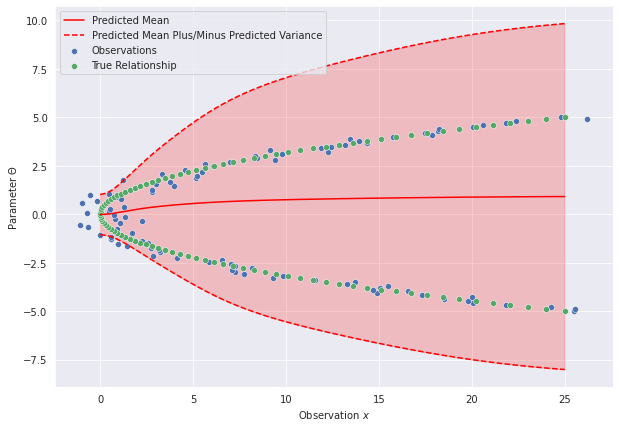

In [15]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model_func)

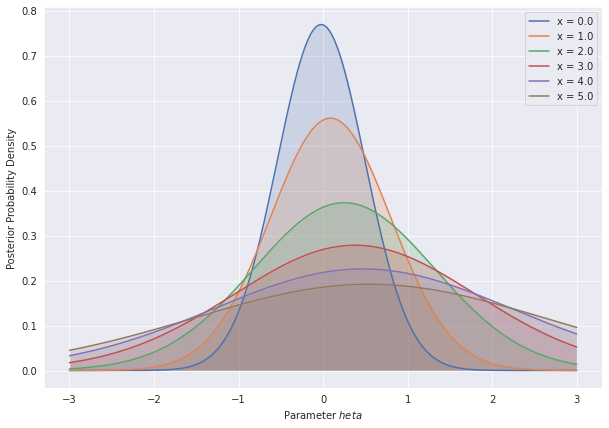

In [16]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)

<AxesSubplot:>

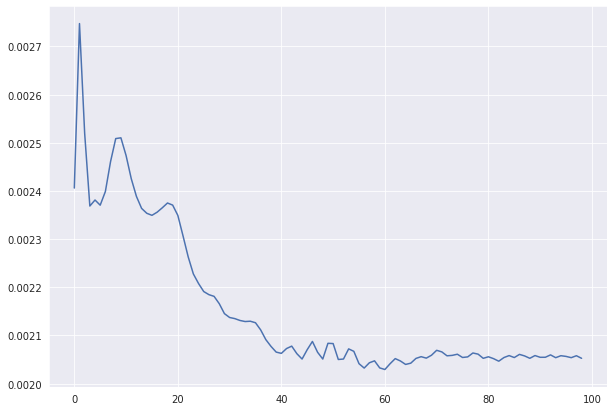

In [17]:
sns.lineplot(x=jnp.arange(len(loss)), y=jnp.array(loss))

In [20]:
theta = amortised_dist.sample_base(10, prngkey)
amortised_dist.logpdf_del_x(theta, data).shape

(100, 10, 1)